# Zadanie 5

Celem ćwiczenia jest implementacja algorytmu Q-learning.

Następnie należy stworzyć agenta rozwiązującego problem [Taxi](https://gymnasium.farama.org/environments/toy_text/taxi/). Problem dostępny jest w pakiecie **gym**.

Punktacja (max 7 pkt):
- Implementacja algorytmu Q-learning. [3 pkt]
- Eksperymenty dla różnych wartości hiperparametrów [2 pkt]
- Jakość kodu [1 pkt]
- Wnioski [1 pkt]


In [7]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt


In [3]:

class QLearningSolver:
    """Class containing the Q-learning algorithm that might be used for different discrete environments."""

    def __init__(
        self,
        observation_space: int,
        action_space: int,
        learning_rate: float = 0.1,
        gamma: float = 0.9, # jak bardzo patrzymy w przyszłość
        epsilon: float = 0.1, # jak często wybieramy losową akcję
    ):
        self.observation_space = observation_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon

        # tablica stanów i akcji
        self.q_table = np.zeros((self.observation_space, self.action_space))

    def __call__(self, state: int, action: int) -> float:
        """Return Q-value of given state and action."""
        return self.q_table[state, action]

    def update(self, state: int, action: int, reward: float) -> None:
        """Update Q-value of given state and action."""
        self.q_table[state, action] = reward

    def get_best_action(self, state: int) -> float:
        """Return action that maximizes Q-value for a given state."""
        return np.argmax(self.q_table[state, :])

    def calculate_reward(self, current_state, action, next_state, reward) -> float:
        """Return maximum Q-value for a given state."""
        learning_rate = self.learning_rate
        gamma = self.gamma
        new_reward = (1 - learning_rate) * self(current_state, action)  + learning_rate * (reward + gamma * (max(self.q_table[next_state, :])))
        return new_reward

    def __repr__(self):
        """Elegant representation of Q-learning solver."""
        return f"QLearningSolver: observation_space: {self.observation_space}, " \
                f"action_space: {self.action_space}\n" \
                f"Learning rate: {self.learning_rate}, gamma: {self.gamma}, epsilon: {self.epsilon}\n" \
                f"Qtable: \n{self.q_table}"

    def __str__(self):
        return self.__repr__()

Trenowanie
==

In [4]:
def train(episodes: int, max_iterations_per_episode: int, learning_rate: float, gamma: float, epsilon: float) -> QLearningSolver:
    q_solver = QLearningSolver(500, 6, learning_rate, gamma, epsilon)

    env = gym.make('Taxi-v3')

    for i in range(episodes):
        starting_state = env.reset()
        current_state = starting_state[0]

        is_finished = None
        iterations = 0

        while not is_finished and iterations <= max_iterations_per_episode:
            # sprawdzamy czy będziemy losować ruch
            random_number = np.random.uniform(0, 1)
            if random_number < q_solver.epsilon:
                action = env.action_space.sample()
            else:
                action = q_solver.get_best_action(current_state)

            # wybieramy akcję i sprawdzamy co się stało
            next_state, reward, is_finished, _, _ = env.step(action)

            # liczymy nagrodę :
            new_reward = q_solver.calculate_reward(current_state, action, next_state, reward)

            q_solver.update(current_state, action, new_reward)
            current_state = next_state
            iterations += 1

    env.close()
    return q_solver

Wizualizacja
==
Nie wyskakuje okno w jupyterze, więc to lepiej to pokazać w tym pliku osobnym

In [10]:
def visualization(episodes: int, max_iterations_per_episode: int, max_steps_in_episode: int):
    env = gym.make('Taxi-v3', render_mode='human', max_episode_steps=max_steps_in_episode)
    starting_state = env.reset()
    current_state = starting_state[0]
    q_solver = train(episodes, max_iterations_per_episode, 0.1, 0.9, 0.1)

    is_finished = None
    is_truncated = None
    while not is_finished and not is_truncated:
        env.render()

        action = q_solver.get_best_action(current_state)
        print("Najlepsza akcaja:", action)

        next_state, _, is_finished, is_truncated, info = env.step(action)
        current_state = next_state
        print("Aktualnie można wykonać akcje: " + str(info['action_mask']))
        print(q_solver)

    env.render()
    env.close()

In [12]:
visualization(4000, 300, 35)

# Eksperymenty

1.Wpływ wartości epsilona na wyniki algorytmu q_learning
--

W tym badaniu będziemy badać wpływ wartości epsilona (wartości jak często bierzemy losową akcję) na wyniki algorytmu
Będziemy szukać ilości wygranych gier w 30 próbach
Posłużą nam do tego pomocniczne funkcje :

In [29]:
# funkcja zliczająca sukcesy

def calculate_wins(amount_of_tests: int, q_solver:QLearningSolver, max_steps_in_episode: int):
    env = gym.make('Taxi-v3',max_episode_steps=max_steps_in_episode)
    wins = 0

    for i in range(amount_of_tests):
        starting_state = env.reset()
        current_state = starting_state[0]

        is_finished = None
        is_truncated = None
        while not is_finished and not is_truncated:
            action = q_solver.get_best_action(current_state)
            next_state, _, is_finished, is_truncated, info = env.step(action)
            current_state = next_state

            if is_finished:
                wins += 1
    return wins

In [51]:
def test_epsilon_values(amount_of_episodes, max_iterartions,num_tests=30, max_steps_in_episode=50):
    epsilon_values = np.arange(0.1, 1, 0.1)
    wins_per_epsilon = []

    for epsilon in epsilon_values:
        q_solver = train(amount_of_episodes, max_iterartions, 0.1, 0.9, epsilon)  # Przykładowe wartości learning_rate=0.1, gamma=0.9
        wins = calculate_wins(num_tests, q_solver, max_steps_in_episode)
        wins_per_epsilon.append(wins/num_tests)

    return epsilon_values, wins_per_epsilon


Pierwszy test przeprowadzimy dla wartości epsilonu od 0.1 do 1.0
- ilość epizodów : 1000
- gamma 0.9
- learning rate : 0.1
- liczba gier na testane wartości : 30
- liczba kroków w epizodzie : 150


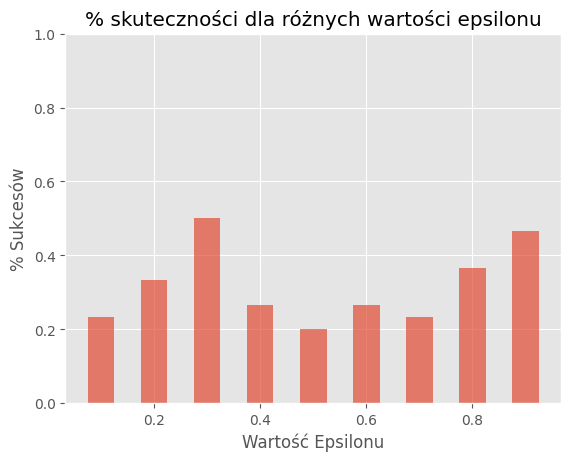

In [54]:
epsilon_values, wins = test_epsilon_values(1000, 150)

plt.bar(epsilon_values, wins, align='center', alpha=0.7, width=0.05)
plt.xlabel('Wartość Epsilonu')
plt.ylabel('% Sukcesów')
plt.title('% skuteczności dla różnych wartości epsilonu')
plt.ylim(0, 1)
plt.show()

Drugi test przeprowadzimy dla wartości epsilonu od 0.1 do 1.0
- ilość epizodów : 2500   (zwiększamy ilość epizodów w trenowaniu, względem pierwszego testu)
- maxymalna liczba iteracji 150 (do trenowania)
- gamma 0.9
- learning rate : 0.1
- liczba gier na testane wartości : 30
- liczba kroków w epizodzie : 150


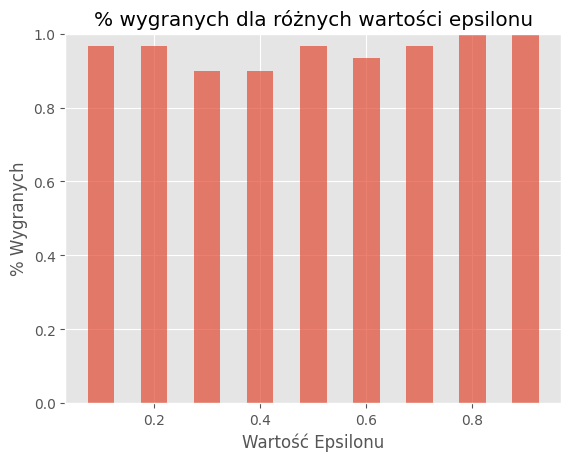

In [49]:
epsilon_values, wins = test_epsilon_values(2500, 150)

plt.bar(epsilon_values, wins, align='center', alpha=0.7, width=0.05)
plt.xlabel('Wartość Epsilonu')
plt.ylabel('% Wygranych')
plt.title('% wygranych dla różnych wartości epsilonu')
plt.ylim(0, 1)
plt.show()

Wnioski
--
- Duża ilość epizodów wpływa, że dla każdej wartości epsilona jesteśmy w stanie osiągnąć wysoką skuteczność algorytmu
- Dla mniejszej ilości epizodów, opcjonalne są wartości mniejsze niż 0.4 (zapewniają największą skuteczność), a większe wartości zbytnio wpływają na losowość przez co psują skuteczność algorytmu (nie może być zbyt dużej eksploracji)

2.Wpływ wartości gammy na wyniki algorytmu q_learning
--

W tym badaniu będziemy badać wpływ wartości gammy ( współczynnik jak bardzo patrzymy nw przyszłość) na wyniki algorytmu
Będziemy szukać ilości wygranych gier w 30 próbach
Wartości takie jak learning_rate i epsilon będą stałe i równe odpowiednio 0.1 i 0.1

In [40]:
def test_gamma_values(amount_of_episodes, max_iterartions,num_tests=30):
    gamma_values = np.arange(0.1, 1.0, 0.1)
    wins_per_gamma = []

    for gamma in gamma_values:
        q_solver = train(amount_of_episodes, max_iterartions, 0.1, gamma, 0.1)  # Przykładowe wartości learning_rate=0.1, gamma=0.9
        wins = calculate_wins(num_tests, q_solver, max_iterartions)
        wins_per_gamma.append(wins/num_tests)

    return gamma_values, wins_per_gamma

Test pierwszy przeprowadzimy dla parametrów : 
- learning_rate = 0.1
- epsilon = 0.1
- gamma w zakresie 0.1 - 1.0
- ilość epizodów = 1000
- iteracje w epizodzie = 150

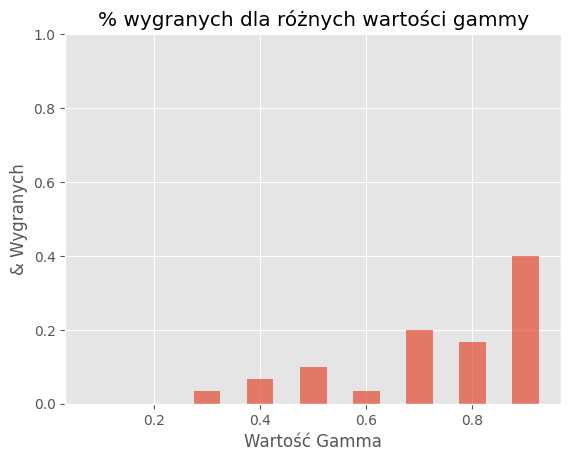

In [41]:
gamma_values, wins = test_gamma_values(1000, 150)

plt.bar(gamma_values, wins, align='center', alpha=0.7, width=0.05)
plt.xlabel('Wartość Gamma')
plt.ylabel('& Wygranych')
plt.title('% wygranych dla różnych wartości gammy')
plt.ylim(0, 1)
plt.show()

Drugi test przeprowadzimy dla parametrów : 
- learning_rate = 0.1
- epsilon = 0.1
- gamma w zakresie 0.1 - 1.0
- liczba epizodów = 2500
- iteracje w epizodzie = 150

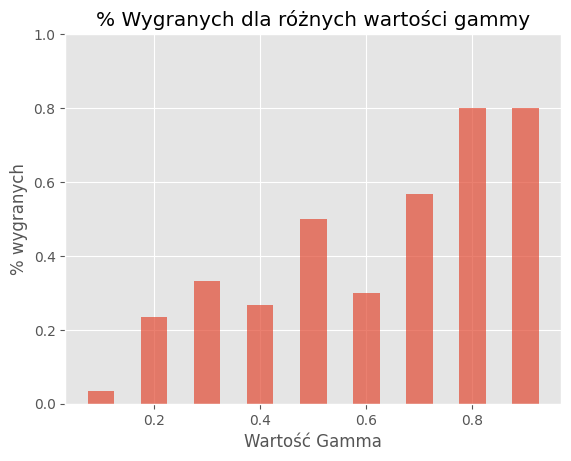

In [55]:
gamma_values, wins = test_gamma_values(2500, 150)

plt.bar(gamma_values, wins, align='center', alpha=0.7, width=0.05)
plt.xlabel('Wartość Gamma')
plt.ylabel('% wygranych')
plt.title('% Wygranych dla różnych wartości gammy')
plt.ylim(0, 1)
plt.show()

Wnioski 
--
- Dla dużych jak i małych ilości epizodów najskutczniejsze są duże wartości gammy np. w przedziale (0.7 - 1.0)
- Ilość epizodów wpływa na ilość sukcesów, więc nawet dla małych wartości gammy uda się osiągnąć sukces
- Dla małych wartości gamm algorytm skupia się na wartościach krótkoterminowych i nie bierze pod uwagę przyszłych zdarzeń


3.Wpływ wartości learning_rate na wyniki algorytmu q_learning
--

W tym badaniu będziemy badać wpływ wartości learning_rate na wyniki algorytmu
Będziemy szukać ilości wygranych gier w 30 próbach
Wartości takie jak gamma i epsilon będą stałe i równe odpowiednio 0.9 i 0.1

In [34]:
def test_learning_rate(amount_of_episodes, max_iterartions,num_tests=30):
    learning_rate_values = np.arange(0.1, 1.0, 0.1)
    wins_per_learing_rate = []

    for learning_rate in learning_rate_values:
        q_solver = train(amount_of_episodes, max_iterartions, learning_rate, 0.9, 0.1)  # Przykładowe wartości learning_rate=0.1, gamma=0.9
        wins = calculate_wins(num_tests, q_solver, max_iterartions)
        wins_per_learing_rate.append(wins/num_tests)

    return learning_rate_values, wins_per_learing_rate

Pierwszy test przeprowadzimy dla parametrów : 
- learning_rate w zakresie 0.1 - 1.0
- epsilon = 0.1
- gamma = 0.9
- liczba epizodów = 1000
- iteracje w epizodzie = 150

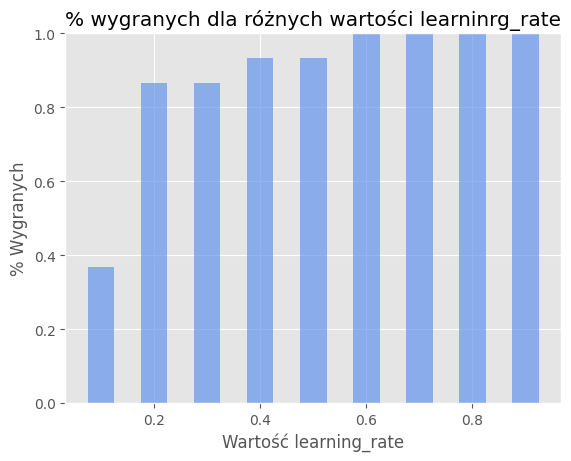

In [37]:
learning_rate_values, wins = test_learning_rate(1000, 150)

plt.bar(learning_rate_values, wins, align='center', alpha=0.7, width=0.05)
plt.xlabel('Wartość learning_rate')
plt.ylabel('% Wygranych')
plt.title('% wygranych dla różnych wartości learninrg_rate')
plt.ylim(0, 1)
plt.show()

Drugi test przeprowadzimy dla parametrów : 
- learning_rate w zakresie 0.1 - 1.0
- epsilon = 0.1
- gamma = 0.9
- liczba epizodów = 500
- iteracje w epizodzie = 150

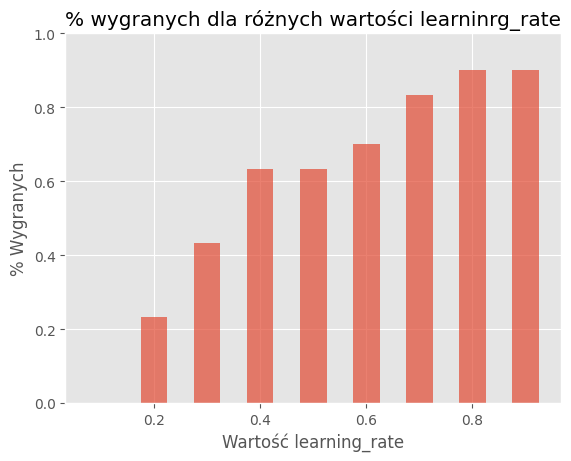

In [58]:
learning_rate_values, wins = test_learning_rate(500, 150)

plt.bar(learning_rate_values, wins, align='center', alpha=0.7, width=0.05)
plt.xlabel('Wartość learning_rate')
plt.ylabel('% Wygranych')
plt.title('% wygranych dla różnych wartości learninrg_rate')
plt.ylim(0, 1)
plt.show()

Wnioski
-- 
- Learning rate odpowiada za tępo z jakim nasz algorytm się uczy
- Dla dużych ilości epizodów, wartość learning_rate nie ma aż tak dużego wpływu, i zadowalające wyniki określa już dla małych wartości
- Natomiast jeżeli będziemy zmniejszać ilość epizodów to zauważymy spadek jakości dla mniejszych wartości learing_rate i raczej wtedy warto korzystać z większych wartości

4.Wpływ liczby epizodów na wyniki
--

W tym badaniu będziemy badać wpływ wilości epizodów na których nasz obiekt się uczy na poprawne działanie algorytmu

Paramtry : 
- learinng_rate = 0.1
- gamma = 0.9
- epsilon = 0.1
- liczba epizodów w zakresie 250 - 10000
- liczba iteracji w epizodzie = 50

In [31]:
def test_amount_of_episodes(num_tests=30, max_iterations=50):
    episodes_values = np.arange(250, 10001, 250)
    wins_per_episode = []

    for episode in episodes_values:
        q_solver = train(episode, max_iterations, 0.1, 0.9, 0.1)
        wins = calculate_wins(num_tests, q_solver, max_iterations)
        wins_per_episode.append(wins)

    return episodes_values, wins_per_episode

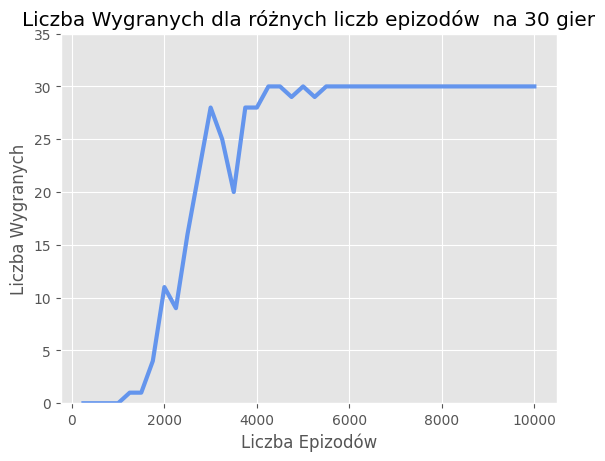

In [33]:
episodes_values, wins = test_amount_of_episodes()

plt.plot(episodes_values, wins, color='cornflowerblue', linewidth=3)
plt.xlabel('Liczba Epizodów')
plt.ylabel('Liczba Wygranych')
plt.title('Liczba Wygranych dla różnych liczb epizodów  na 30 gier')
plt.ylim(0, 35)
plt.show()

Wnioski
--
- Liczba epizodów określa liczbę pełnych interakcji jakie algorytm ma ze środowiskiem i wpływa na to jak się nasz algorytm wyuczy
- Zwiększenie ilości epizodów polepszy jakość działania algorytmu, ponieważ będzie on bardzo dobrze znał już środowisko po jakim się porusza
- Ale od pewnej liczby widzimy już dobrą skuteczność, więc ta liczba epizodów też nie musi być bardzo ogromna, żeby algorytm był skuteczny, ponieważ już po jakimś czasie osiąga wysoką 100% skuteczność

5.Wpływ maksymalnej liczby iteracji w epizodzie
--

W tym badaniu będziemy badać wpływ maxmalnej liczby iteracji w epizodzie na których nasz obiekt się uczy na poprawne działanie algorytmu
Paramtry : 
- learinng_rate = 0.1
- gamma = 0.9
- epsilon = 0.1
- liczba epizodów w zakresie 1000
- liczba iteracji w epizodzie w zakresie 50 - 500

In [24]:
def test_max_iters_per_episode(episodes, num_tests=30, max_steps_in_episode=50):
    max_iters_values = np.arange(50, 501, 50)
    wins_per_gamma = []

    for max_iter in max_iters_values:
        q_solver = train(episodes, max_iter, 0.1, 0.9, 0.1)
        wins = calculate_wins(num_tests, q_solver, max_steps_in_episode)
        wins_per_gamma.append(wins)

    return max_iters_values, wins_per_gamma

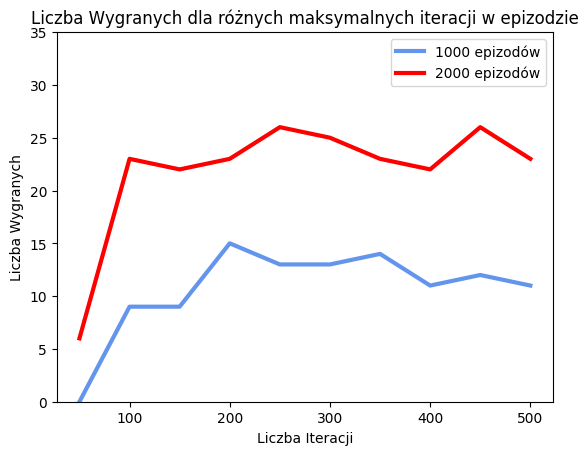

In [26]:
max_iters_value, wins = test_max_iters_per_episode(1000)
max_iters_value2, wins2 = test_max_iters_per_episode(2000)

plt.plot(max_iters_value, wins, color='cornflowerblue', linewidth=3)
plt.plot(max_iters_value2, wins2, color='red', linewidth=3)
plt.xlabel('Liczba Iteracji')
plt.ylabel('Liczba Wygranych')
plt.title('Liczba Wygranych dla różnych maksymalnych iteracji w epizodzie')
plt.ylim(0, 35)
plt.legend(['1000 epizodów', '2000 epizodów'])
plt.show()

Wnioski
--
- Maksymalna ilość kroków określa ile kroków może maksymalnie wygonać algorytm w jednym epizodzie
- Widać, że wraz ze wzrostem liczby iteracji czasem następuje pogorszenie jakości działania algorytmu, a dzieje się tak ponieważ algorytm może zbytnio dostosować się do jakiegoś środowiska
- Z kolei dla małych wartości nasz algorytm może nie znaleźć odpowiednich stanów, przez co działanie zakończy się niepowodzeniem
- Trzeba odpowiednio uczyć algorytm i sprawdzać różne wartości, aby znaleźć jak najlepsze wartości
- Zwiększenie liczby epizodów poprawiłoby działanie algorytmu

6.Wizualizacjia nagród
--

In [11]:

def visualize_reward(q_solver:QLearningSolver, env:gym.Env):
    total_reward = 0
    episode_rewards = []
    for episode in range(1, 2000):
        starting_state, info = env.reset()
        total_episode_reward = 0

        current_state = starting_state

        for step in range(100):
            action = q_solver.get_best_action(current_state)

            next_state, reward, is_finished, is_truncated, info = env.step(action)
            new_reward = q_solver.calculate_reward(current_state, action, next_state, reward)
            q_solver.update(current_state, action, new_reward)

            current_state = next_state
            total_episode_reward += reward

            if is_finished:
                break

        total_reward += total_episode_reward/episode
        episode_rewards.append(total_episode_reward)
    return total_reward, episode_rewards

def test_rewards_for_different_epsilons(list_of_epsilons, env:gym.Env):
    info = []
    for epsilon in list_of_epsilons:
        q_solver = train(1000, 150, 0.1, 0.9, epsilon)
        values = visualize_reward(q_solver, env)
        info.append(values)
    return info



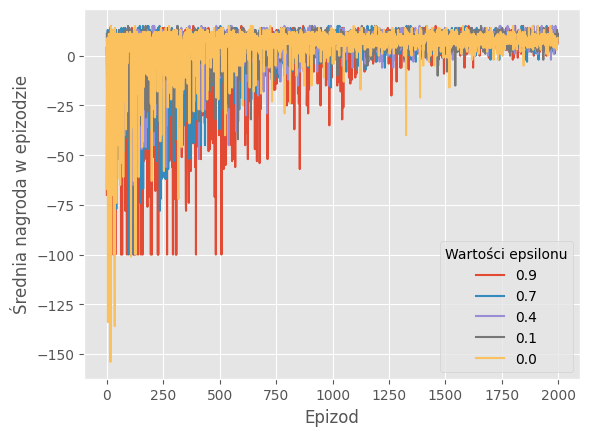

In [56]:
env = gym.make('Taxi-v3')
epsilon_values = [0.9, 0.7, 0.4, 0.1, 0.0]

info = test_rewards_for_different_epsilons(epsilon_values, env)

for i in range(len(info)):
    episode_rewards = info[i][1]
    plt.plot(episode_rewards)
plt.style.use("ggplot")
plt.xlabel("Epizod")
plt.ylabel("Średnia nagroda w epizodzie")
plt.legend(epsilon_values, title="Wartości epsilonu")
plt.show()

Dla różnych learning_rate

In [9]:
def test_rewards_for_different_learning_rate(list_of_learning_rates, env:gym.Env):
    info = []
    for learning_rate in list_of_learning_rates:
        q_solver = train(1000, 150, learning_rate, 0.9, 0.1)
        values = visualize_reward(q_solver, env)
        info.append(values)
    return info

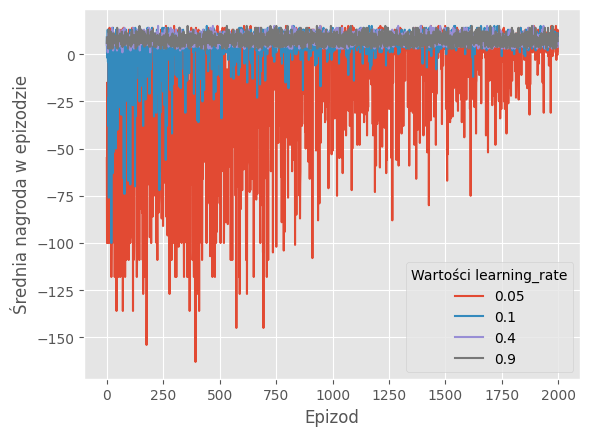

In [19]:
env = gym.make('Taxi-v3')
learning_rate_values = [0.05, 0.1, 0.4, 0.9]

info = test_rewards_for_different_learning_rate(learning_rate_values, env)

for i in range(len(info)):
    episode_rewards = info[i][1]
    plt.plot(episode_rewards)
plt.style.use("ggplot")
plt.xlabel("Epizod")
plt.ylabel("Średnia nagroda w epizodzie")
plt.legend(learning_rate_values, title="Wartości learning_rate")
plt.show()

Dla różnych gamma : 

In [20]:
def test_rewards_for_different_gammas(list_of_gammas, env:gym.Env):
    info = []
    for gamma in list_of_gammas:
        q_solver = train(1000, 150, 0.1, gamma, 0.1)
        values = visualize_reward(q_solver, env)
        info.append(values)
    return info

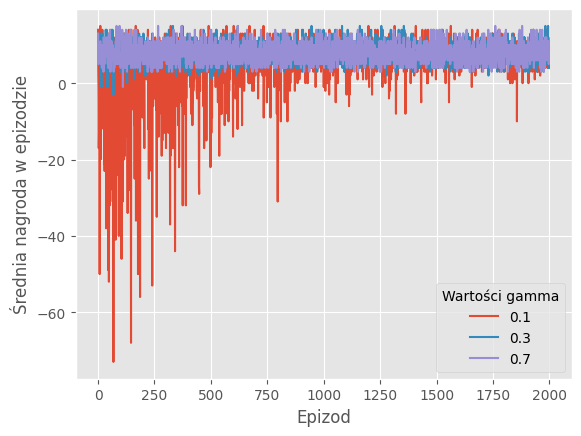

In [25]:
env = gym.make('Taxi-v3')
gamma_values = [0.1, 0.3, 0.7]

info = test_rewards_for_different_learning_rate(gamma_values, env)

for i in range(len(info)):
    episode_rewards = info[i][1]
    plt.plot(episode_rewards)
plt.style.use("ggplot")
plt.xlabel("Epizod")
plt.ylabel("Średnia nagroda w epizodzie")
plt.legend(gamma_values, title="Wartości gamma")
plt.show()